In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ReduceLROnPlateau
import itertools

In [2]:
def load_dataset(dataset_path):
    x_train = []
    y_train = []
    class_names = sorted(os.listdir(dataset_path))

    for class_index, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(class_path, filename)
                    image = cv2.imread(image_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = np.array(image)
                    image = image / 255.0
                    if image is not None:
                        x_train.append(image)
                        y_train.append(class_index)

    x_train = np.array(x_train)
    y_train = np.array(y_train)

    return x_train, y_train

In [3]:
def create_model(input_shape, num_classes):
    # Load the MobileNetV2 model with pre-trained weights on ImageNet
    base_model = MobileNetV2(
        weights='imagenet', 
        include_top=False, 
        input_shape=input_shape
    )
    
    # Add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Add a dense layer with 128 neurons and ReLU activation
    x = Dense(128, activation='relu')(x)
    
    # Add a final dense layer with 4 neurons (one for each class) and softmax activation
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Create the new model with the modified architecture
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze the weights of the base model to avoid overfitting on small datasets
    for layer in base_model.layers:
        layer.trainable = False

    return model

In [4]:
input_shape = (224, 224, 3)
num_classes = 4
batch_size = 32
epochs = 50
lr = 0.001

In [5]:
# Dataset directory
dataset_directory = "data/MSID_US_AUG"

# Load dataset into x_train and y_train arrays
x_train, y_train = load_dataset(dataset_directory)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1)

# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

# Reshaping labelst to (x, 4)
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

x_train.shape, x_val.shape, x_test.shape

((3723, 224, 224, 3), (931, 224, 224, 3), (518, 224, 224, 3))

In [39]:
model = create_model(input_shape, num_classes)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set up the learning rate schedule
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7)

# Train the model using fit_generator with the learning rate schedule
model.fit(
    x_train, 
    y_train_one_hot,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val_one_hot), 
    callbacks=[reduce_lr], 
    verbose=1)

Epoch 1/50
117/117 [==============================] - 30s 247ms/step - loss: 0.4482 - accuracy: 0.8372 - val_loss: 0.2863 - val_accuracy: 0.9023 - lr: 0.0010
Epoch 2/50
117/117 [==============================] - 25s 213ms/step - loss: 0.1526 - accuracy: 0.9519 - val_loss: 0.1827 - val_accuracy: 0.9420 - lr: 0.0010
Epoch 3/50
117/117 [==============================] - 24s 209ms/step - loss: 0.0908 - accuracy: 0.9726 - val_loss: 0.1544 - val_accuracy: 0.9463 - lr: 0.0010
Epoch 4/50
117/117 [==============================] - 25s 211ms/step - loss: 0.0447 - accuracy: 0.9895 - val_loss: 0.1433 - val_accuracy: 0.9549 - lr: 0.0010
Epoch 5/50
117/117 [==============================] - 25s 212ms/step - loss: 0.0230 - accuracy: 0.9970 - val_loss: 0.1488 - val_accuracy: 0.9538 - lr: 0.0010
Epoch 6/50
117/117 [==============================] - 25s 213ms/step - loss: 0.0128 - accuracy: 0.9989 - val_loss: 0.1319 - val_accuracy: 0.9592 - lr: 0.0010
Epoch 7/50
117/117 [==============================] 

In [40]:

# Predict on the validation data
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate the metrics
precision = precision_score(y_test, y_pred_labels, average='macro')
recall = recall_score(y_test, y_pred_labels, average='macro')
f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

# Print the metrics
print(f"Metrics:")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)
print()

17/17 [==============================] - 3s 178ms/step
Metrics:
Precision: 0.9703034034930587
Recall: 0.9705895436849943
F1 Score: 0.9702962183760808
Accuracy: 0.971042471042471



In [34]:
model.save('models/mobilenetv2_split_validation.h5')

In [6]:
model = tf.keras.models.load_model('models/mobilenetv2_split_validation.h5')

2023-06-13 22:31:42.427759: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


17/17 [==============================] - 3s 158ms/step


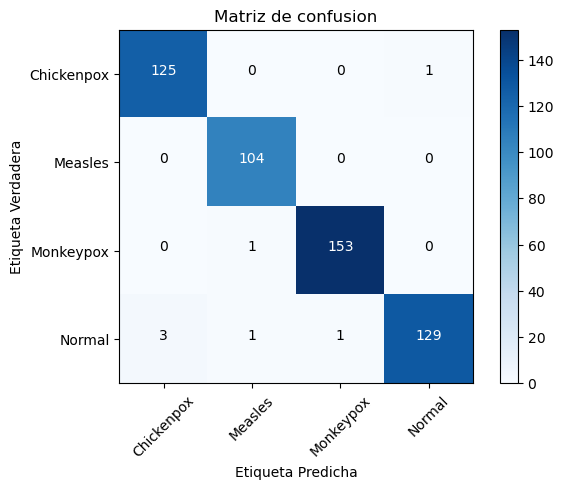

In [7]:
# Predict on the validation data
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)


y_pred_labels = np.argmax(y_pred, axis=1)  

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_labels)

# Obtener las etiquetas de las clases
class_labels = ['Chickenpox', 'Measles', 'Monkeypox', 'Normal']  # Reemplaza con tus etiquetas de clases

# Plotear la matriz de confusión
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de confusion')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Agregar los valores de la matriz en cada celda
thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')

# Mostrar el plot
plt.show()